In [ ]:
# !pip install  scikit-learn pandas matplotlib tqdm gradio
# !pip install kagglehub
# !pip install torch torchvision
# !pip install opencv-python

In [2]:
# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, models, transforms
from torchvision.datasets import DatasetFolder, ImageFolder

# Scikit-learn
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

# Misc
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import kagglehub
from PIL import Image

In [3]:
# Function to find imaghes because I have a custom folder structure that is hard to load directly
def find_images(folder_path, label):
    images = []
    for file in os.listdir(folder_path):
        if file.lower().endswith((".jpg", ".jpeg", ".png")):
            images.append((os.path.join(folder_path, file), label))
    return images

data_dir = kagglehub.dataset_download("bharathry/glaucoma-dataset-for-ai-diagnosis-v2")
print("Downloaded at:", data_dir)

# Point to the actual subfolder that contains glaucoma/ and normal/ because the dataset is nested with folders
data_dir = os.path.join(data_dir, "Glaucoma Dataset for AI Diagnosis")
print("Current Data Dir:", data_dir)
print("Top-Level Folders:", os.listdir(data_dir))

glaucoma_images = find_images(os.path.join(data_dir, "glaucoma"), 1)
normal_images = find_images(os.path.join(data_dir, "normal"), 0)

all_images = glaucoma_images + normal_images

# Stratified train/val split because we have an imbalanced dataset
from sklearn.model_selection import train_test_split
train_idx, val_idx = train_test_split(
    range(len(all_images)),
    test_size=0.2,
    stratify=[label for _, label in all_images],
    random_state=42
)

train_split = [all_images[i] for i in train_idx]
val_split = [all_images[i] for i in val_idx]

print("Train samples:", len(train_split))
print("Val samples:", len(val_split))

100%|██████████| 2.67G/2.67G [06:22<00:00, 7.50MB/s]

Extracting files...


Downloaded at: /Users/bharathreddy/.cache/kagglehub/datasets/bharathry/glaucoma-dataset-for-ai-diagnosis-v2/versions/1
Current Data Dir: /Users/bharathreddy/.cache/kagglehub/datasets/bharathry/glaucoma-dataset-for-ai-diagnosis-v2/versions/1/Glaucoma Dataset for AI Diagnosis
Top-Level Folders: ['glaucoma', 'normal']
Train samples: 2527
Val samples: 632


In [ ]:
# Custom dataset class I creasted to traverse the custom folder structure properly
class CustomDataset(Dataset):
    def __init__(self, image_list, transform=None):
        self.image_list = image_list
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_path, label = self.image_list[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

IMG_SIZE = 224
BATCH_SIZE = 32

# Augmented transform for training
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.85, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.15, contrast=0.15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Simpler transform for validation
val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dataset = CustomDataset(train_split, transform=train_transform)
val_dataset = CustomDataset(val_split, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

In [5]:
# Load the pre-trained MobileNetV3 model so I can train it on my custom dataset
model = models.mobilenet_v3_large(pretrained=True)

model.classifier[2] = nn.Dropout(p=0.4)
model.classifier[3] = nn.Linear(model.classifier[3].in_features, 2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

C:\Users\bhara\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\bhara\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
EPOCHS = 30
PATIENCE = 5 # Early stopping patience, I need this because my model overfits quickly and easily on my dataset even after augmenting it

# These next four lines were so I could make graphs for training and validation losses and accuracies
# I don't need to change these, but I will leave them here for reference
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
all_val_preds_by_epoch = []
all_val_labels_by_epoch = []

best_val_loss = float("inf")
best_weights = None
early_stop_counter = 0

for epoch in range(EPOCHS):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = outputs.max(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    epoch_val_preds = []
    epoch_val_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, preds = outputs.max(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            epoch_val_preds.extend(preds.cpu().numpy())
            epoch_val_labels.extend(labels.cpu().numpy())

    val_loss /= len(val_loader)
    val_acc = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Store epoch-wise predictions for metrics
    all_val_preds_by_epoch.append(epoch_val_preds)
    all_val_labels_by_epoch.append(epoch_val_labels)

    print(
        f"Epoch {epoch+1}: "
        f"Train Loss = {train_loss:.4f}, Train Acc = {train_acc:.2f}% | "
        f"Val Loss = {val_loss:.4f}, Val Acc = {val_acc:.2f}%"
    )

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_weights = model.state_dict()
        early_stop_counter = 0
        print("New best model found (val_loss improved).")
    else:
        early_stop_counter += 1
        if early_stop_counter >= PATIENCE:
            print("Early stopping triggered.")
            break

# Load best model
model.load_state_dict(best_weights)
torch.save(best_weights, "best_glaucoma_model.pth")

Epoch 1/30: 100%|██████████| 79/79 [02:01<00:00,  1.54s/it]


Epoch 1: Train Loss = 0.1915, Train Acc = 91.37% | Val Loss = 0.2106, Val Acc = 94.30%


Epoch 2/30: 100%|██████████| 79/79 [02:58<00:00,  2.26s/it]


Epoch 2: Train Loss = 0.1040, Train Acc = 95.25% | Val Loss = 0.1304, Val Acc = 95.09%


Epoch 3/30: 100%|██████████| 79/79 [02:49<00:00,  2.14s/it]


Epoch 3: Train Loss = 0.0931, Train Acc = 96.04% | Val Loss = 0.1102, Val Acc = 95.25%


Epoch 4/30: 100%|██████████| 79/79 [02:48<00:00,  2.13s/it]


Epoch 4: Train Loss = 0.0770, Train Acc = 96.83% | Val Loss = 0.1122, Val Acc = 95.41%


Epoch 5/30: 100%|██████████| 79/79 [02:58<00:00,  2.26s/it]


Epoch 5: Train Loss = 0.0498, Train Acc = 98.34% | Val Loss = 0.1384, Val Acc = 95.25%


Epoch 6/30: 100%|██████████| 79/79 [02:56<00:00,  2.23s/it]


Epoch 6: Train Loss = 0.0364, Train Acc = 98.73% | Val Loss = 0.1828, Val Acc = 94.15%


Epoch 7/30: 100%|██████████| 79/79 [03:02<00:00,  2.30s/it]


Epoch 7: Train Loss = 0.0310, Train Acc = 98.93% | Val Loss = 0.1503, Val Acc = 94.78%


Epoch 8/30: 100%|██████████| 79/79 [02:56<00:00,  2.24s/it]


Epoch 8: Train Loss = 0.0145, Train Acc = 99.60% | Val Loss = 0.2458, Val Acc = 94.94%


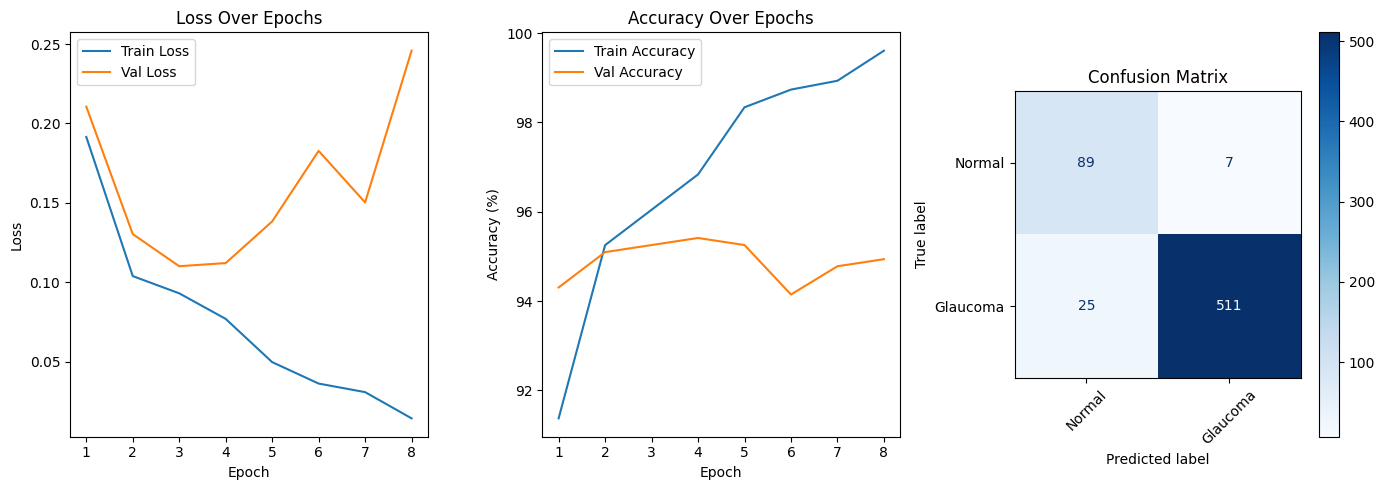

In [ ]:
epochs_range = range(1, len(train_losses) + 1)

plt.figure(figsize=(14, 5))

# Loss plot
plt.subplot(1, 3, 1)
plt.plot(epochs_range, train_losses, label="Train Loss")
plt.plot(epochs_range, val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Over Epochs")
plt.legend()

# Accuracy plot
plt.subplot(1, 3, 2)
plt.plot(epochs_range, train_accuracies, label="Train Accuracy")
plt.plot(epochs_range, val_accuracies, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Over Epochs")
plt.legend()

# Confusion Matrix
plt.subplot(1, 3, 3)
cm = confusion_matrix(epoch_val_labels, epoch_val_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Glaucoma"])
disp.plot(cmap="Blues", values_format="d", ax=plt.gca())
plt.xticks(rotation=45)
plt.title("Confusion Matrix")

plt.tight_layout()
plt.savefig("glaucoma_results.png")
plt.show()

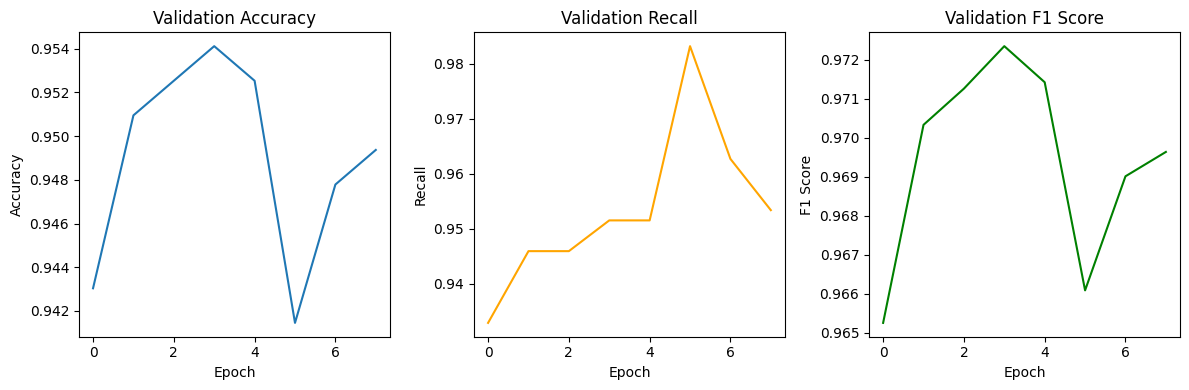

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, f1_score

val_metrics = {
    "accuracy": [],
    "recall": [],
    "f1_score": []
}

# Compute metrics per epoch
for epoch_preds, epoch_labels in zip(all_val_preds_by_epoch, all_val_labels_by_epoch):
    val_metrics["accuracy"].append(accuracy_score(epoch_labels, epoch_preds))
    val_metrics["recall"].append(recall_score(epoch_labels, epoch_preds))
    val_metrics["f1_score"].append(f1_score(epoch_labels, epoch_preds))

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(val_metrics["accuracy"], label="Accuracy")
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.subplot(1, 3, 2)
plt.plot(val_metrics["recall"], label="Recall", color="orange")
plt.title("Validation Recall")
plt.xlabel("Epoch")
plt.ylabel("Recall")

plt.subplot(1, 3, 3)
plt.plot(val_metrics["f1_score"], label="F1 Score", color="green")
plt.title("Validation F1 Score")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")

plt.tight_layout()
plt.show()